In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Load the processed data
df = pd.read_csv('../data/processed/heart_processed.csv')

# Separate Features (X) and Target (y)
X = df.drop("condition", axis=1)
y = df["condition"]

# Train-Test Split (80% Training, 20% Testing)
# stratify=y ensures we have the same ratio of sick/healthy in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Training Shape: (773, 17)
Testing Shape: (194, 17)


In [4]:
# 1. Define the Parameter Grid (The "Settings" we want to test)
param_grid = {
    'max_depth': [3, 5, 7, 10, None],          # How deep can the tree grow?
    'min_samples_leaf': [1, 2, 5, 10],         # Min samples required to be a leaf node
    'criterion': ['gini', 'entropy']           # How to measure "purity"
}

# 2. Initialize Grid Search
dt = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(dt, param_grid, cv=5, scoring='recall') # Optimizing for RECALL (Safety)

# 3. Train
grid_search_dt.fit(X_train, y_train)

# 4. Get Best Model
best_dt = grid_search_dt.best_estimator_

print("Best Parameters:", grid_search_dt.best_params_)
print("Best Recall Score:", grid_search_dt.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10}
Best Recall Score: 0.5013116236996834


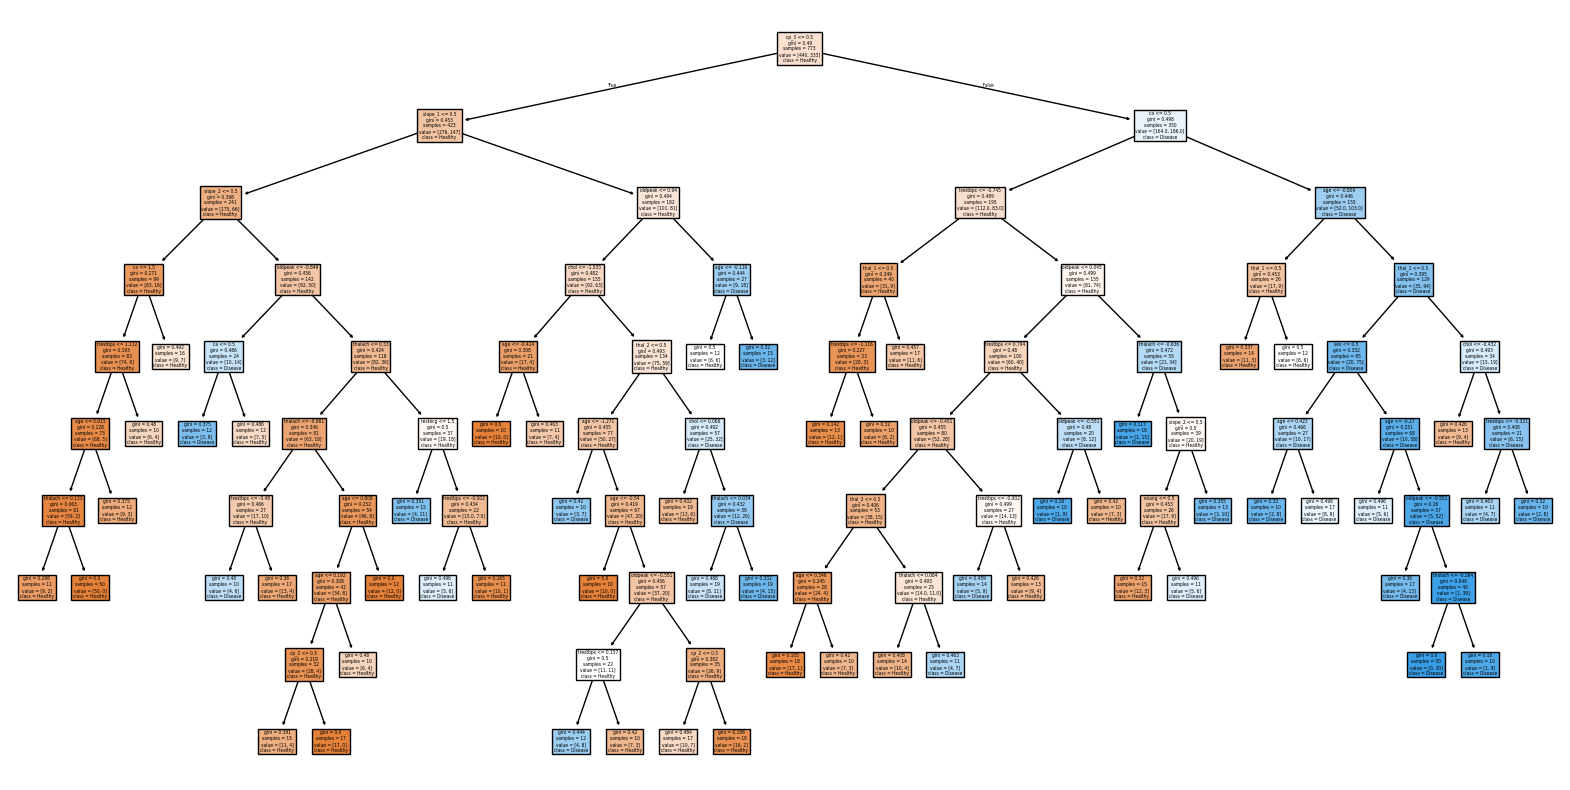

In [5]:
plt.figure(figsize=(20,10))
plot_tree(best_dt, feature_names=X.columns, class_names=['Healthy', 'Disease'], filled=True)
plt.show()

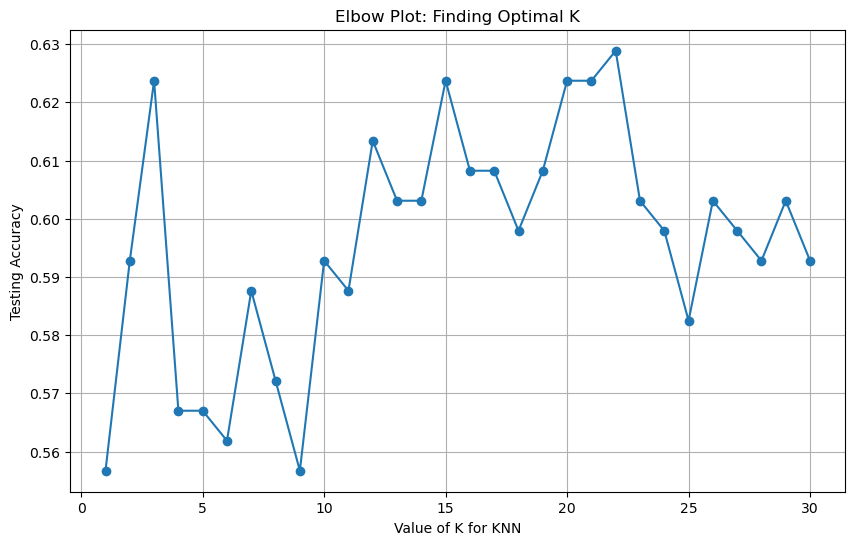

Optimal K found: 22


KNeighborsClassifier(n_neighbors=22)

In [6]:
# 1. Test K values from 1 to 30
k_range = range(1, 31)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

# 2. Plot the "Elbow Curve"
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o')
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.title('Elbow Plot: Finding Optimal K')
plt.grid(True)
plt.show()

# 3. Train Final KNN with best K (e.g., let's say 5 or 7 based on plot)
best_k = k_range[np.argmax(scores)]
print(f"Optimal K found: {best_k}")
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

--- Decision Tree Report ---


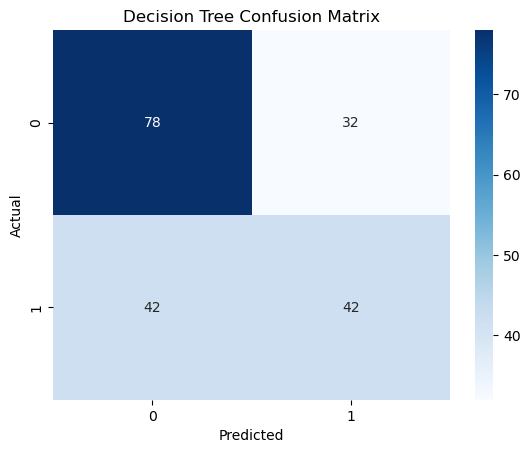

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       110
           1       0.57      0.50      0.53        84

    accuracy                           0.62       194
   macro avg       0.61      0.60      0.60       194
weighted avg       0.61      0.62      0.61       194



--- KNN Report ---


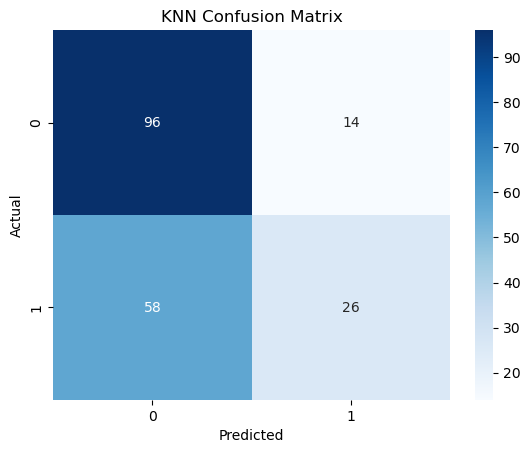

              precision    recall  f1-score   support

           0       0.62      0.87      0.73       110
           1       0.65      0.31      0.42        84

    accuracy                           0.63       194
   macro avg       0.64      0.59      0.57       194
weighted avg       0.63      0.63      0.59       194



--- Logistic Regression (Baseline) Report ---


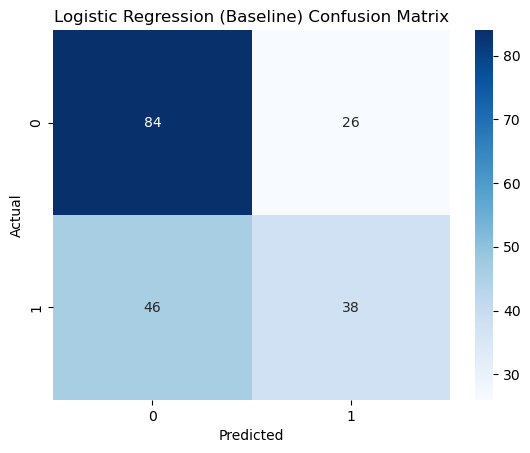

              precision    recall  f1-score   support

           0       0.65      0.76      0.70       110
           1       0.59      0.45      0.51        84

    accuracy                           0.63       194
   macro avg       0.62      0.61      0.61       194
weighted avg       0.62      0.63      0.62       194





In [7]:
models = {
    'Decision Tree': best_dt,
    'KNN': best_knn,
    'Logistic Regression (Baseline)': LogisticRegression(max_iter=1000).fit(X_train, y_train)
}

for name, model in models.items():
    print(f"--- {name} Report ---")
    y_pred = model.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Metrics
    print(classification_report(y_test, y_pred))
    print("\n")

C:\Users\Dell\AppData\Local\Temp\ipykernel_11432\2451932323.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=X.columns[indices], palette="viridis")


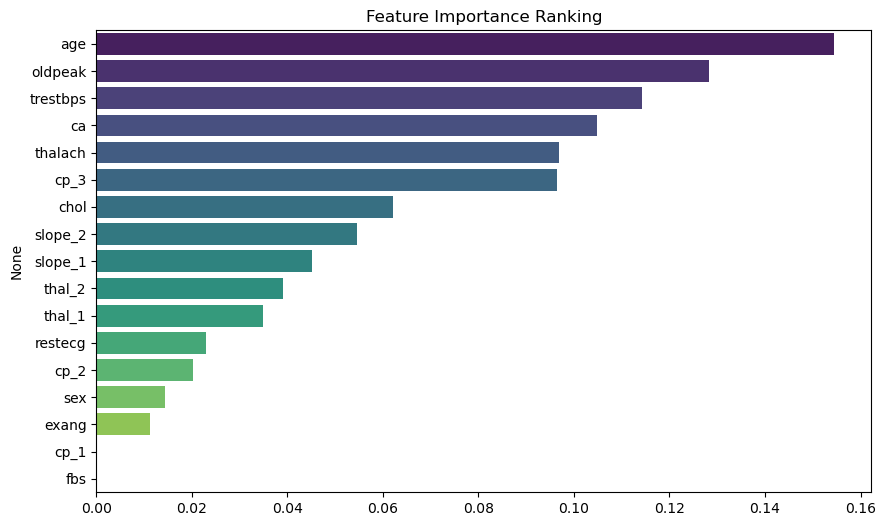

In [8]:
# Extract importance
importances = best_dt.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X.columns[indices], palette="viridis")
plt.title("Feature Importance Ranking")
plt.show()

In [9]:
import pickle

# Let's assume Decision Tree won
filename = '../models/final_model_dt.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_dt, file)

print(f"Model saved successfully to {filename}")

Model saved successfully to ../models/final_model_dt.pkl


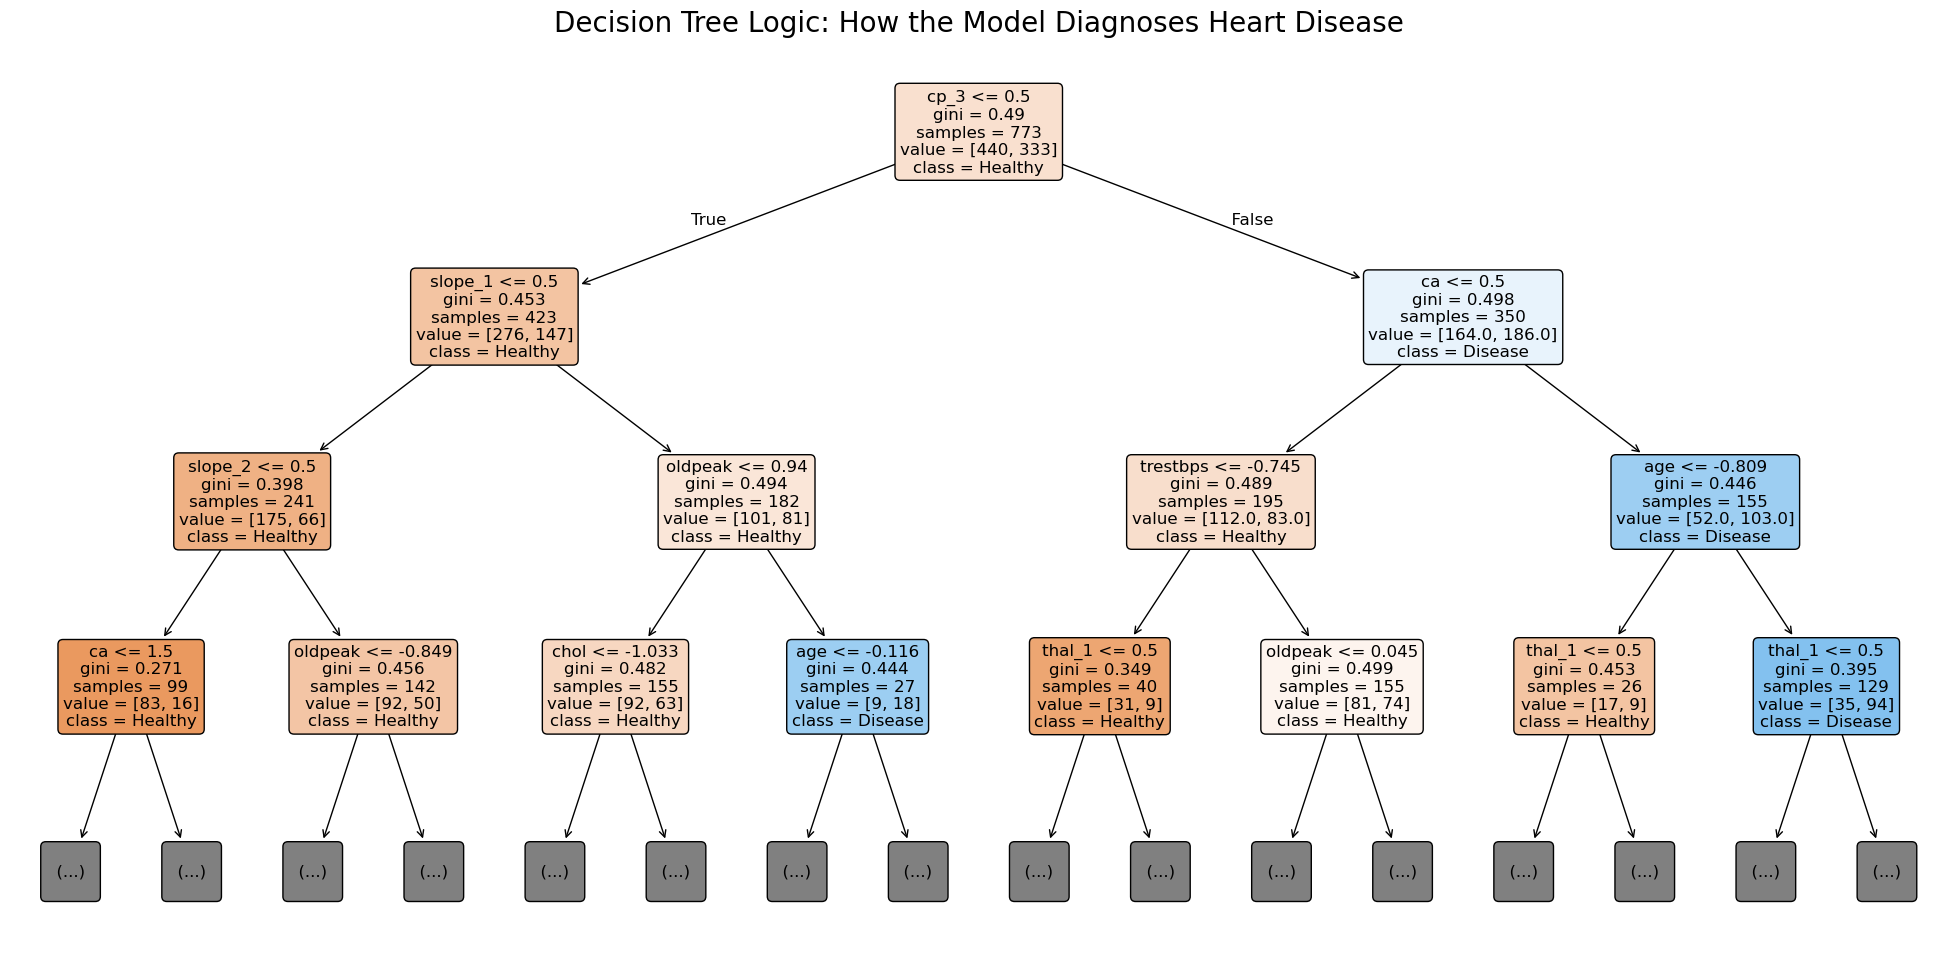

In [10]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# 1. Set up the figure size for better readability
plt.figure(figsize=(25, 12))

# 2. Plot the tree
plot_tree(
    best_dt, 
    feature_names=X.columns, 
    class_names=['Healthy', 'Disease'], 
    filled=True,             # Colors nodes by majority class
    rounded=True,            # Rounded corners for aesthetics
    fontsize=12,
    max_depth=3              # Limiting depth for visual clarity
)

plt.title("Decision Tree Logic: How the Model Diagnoses Heart Disease", fontsize=20)
plt.show()